### Regime Identification in Multivariate Time-series

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import regimes
import numpy as np
import pandas as pd
import seaborn as sns
from clasp import ClaSP
from scipy import stats
from spdms import getSPDMs
from scipy.stats import norm
# import statsmodels.api as sm
# from sklearn import metrics
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

np.random.seed(1)

In [3]:
import parameters
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from spdms import getSPDMs
# from sklearn import metrics
# import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
plt.rcParams['figure.dpi'] = 200


from sklearn import metrics
from scipy.spatial.distance import cdist


# import autograd.numpy as np
from functools import reduce
from pymanopt import Problem
from pymanopt.manifolds import Stiefel
from pymanopt.optimizers.trust_regions import TrustRegions
import pymanopt



# Parameters
pars = parameters.get_syn_params()
win_size = pars.get("win_size")
slidingwin_size = pars.get("slidingwin_size")
plot_path = pars.get("plot_path")


def create_cost_and_derivatives(manifold, A):
    @pymanopt.function.autograd(manifold)
    def cost(x):
        T = A.shape[2]
        c = 0
        
        for i in range(T):
            c = c - (reduce(np.dot, [x.T, A[:,:,i], x, x.T, A[:,:,i], x])).trace()
        
        return c
    
    @pymanopt.function.autograd(manifold)
    def egrad(x):
        T = A.shape[2]
        gr = np.zeros(x.shape)
        
        for i in range(T):
            gr = gr - 4 * reduce(np.dot, [A[:,:,i], x, x.T, A[:,:,i], x])
        
        return gr
    return cost, egrad

def ManoptOptimization(A,m):
    n = A.shape[0]
    T = A.shape[2]
    manifold = Stiefel(n,m,k=1)

    cost,egrad = create_cost_and_derivatives(manifold, A)
    
    problem = Problem(manifold=manifold, cost = cost, euclidean_gradient= egrad)
    
    solver = TrustRegions(max_iterations=1)
    print('# Start optimization using solver: trustregion')
    Xopt = solver.run(problem)
    
    return Xopt

def reduce_dimension(covseqs, m):
    print(f'Covariance matrix shape: {covseqs.shape}')
    n,n,T,L = covseqs.shape    
    traj = np.zeros((m, m, T, L))
    B = np.zeros((n,m))
    
    for j in range(L):
        B = ManoptOptimization(covseqs[:,:,:,j], m)
        for i in range(T):
            traj[:,:,i,j] = reduce(np.dot, [B.point.T, covseqs[:,:,i,j], B.point])
            
    return traj 
                

In [4]:
def getSPDMs(data, winsize, use_corr, regularization):
        start = 0
        covar = []
        dim = data.shape[1] 
        cluster_idx = []
    
        while start+winsize < len(data)-1:
            cluster_idx.append(start)
            data_batch = data[start: start + winsize].transpose()
            
            if use_corr:
                cov = np.corrcoef(data_batch)
            else:
                cov = np.cov(data_batch)

            #if not np.all(np.linalg.eigvals(cov) > 0.0001):
            #if regularization:
            cov = cov + np.eye(cov.shape[0])* regularization 
            covar.append(cov)
            start = start +1 
        return np.array(covar), cluster_idx 

In [5]:
# Normalization (Standard)
def normalize(data, type='minmax'):

    if type=='std':
        return (np.array(data) - np.mean(data))/np.std(data)
        
    elif type=='minmax':
        return (np.array(data) - np.min(data))/(np.max(data) - np.min(data))

In [6]:
# Read real data (tectonic-climate time series)
# data = pd.read_csv(r'../datasets/moxa_data_D.csv')

# Read synthetically generated time series
data = pd.read_csv(r'../datasets/synthetic_datac.csv')

In [7]:
# rdata = reduce_dimension(spdms, 2)
# spdms = np.take(rdata, 0, axis=3)
# print(spdms.shape)
# rdata[:, :, :, 0].shape

In [8]:
# np.transpose(rdata[:, :, :, 0]).shape

In [9]:
start, end = '2014-11-01', '2016-12-30'

# Appy mask get a segment from time series
# mask = (data['DateTime'] > '2014-11-01') & (data['DateTime'] <= '2015-12-28')
# data = data.loc[mask]

# data = data.fillna(method='pad')
# data = data.set_index('DateTime')
# data = data[start: end]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1100 entries, 0 to 1099
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Z1      1100 non-null   float64
 1   Z2      1100 non-null   float64
 2   Z3      1100 non-null   float64
 3   Z4      1100 non-null   float64
 4   Z5      1100 non-null   float64
dtypes: float64(5)
memory usage: 51.6 KB


In [10]:
data.isnull().sum()

Z1    0
Z2    0
Z3    0
Z4    0
Z5    0
dtype: int64

In [11]:
data = data.apply(normalize)

In [12]:
data.isnull().sum()

Z1    0
Z2    0
Z3    0
Z4    0
Z5    0
dtype: int64

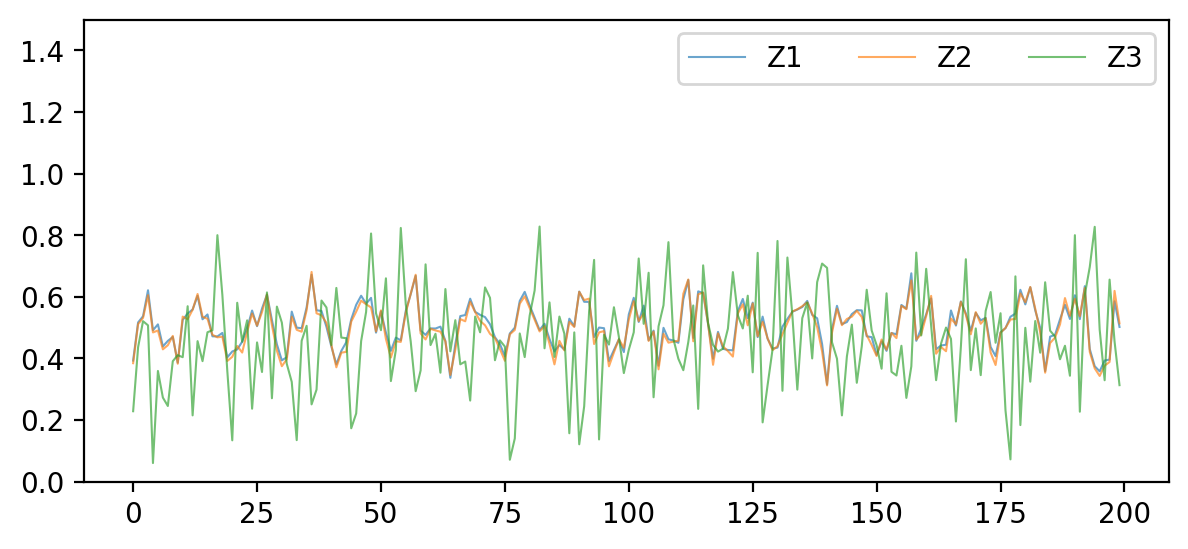

In [13]:
# toplot = [ 'rain', 'snow_load', 'pressure_outside','gw_mb', 'gw_sg', 'gw_west', 'strain_ns_corrected']
# toplot = ['gw_mb', 'gw_sg', 'temperature_outside', 'strain_ew_corrected', 'strain_ns_corrected']
toplot = ['Z1', 'Z2','Z3']

for i in toplot:
    data[i][:200].plot(use_index=True, figsize=(7, 3), linewidth=0.75, alpha=0.66)
    plt.legend(toplot, frameon=True, ncol=3)


plt.ylim(0, 1.5)
# plt.gcf().autofmt_xdate()
# plt.legend(['Temperature', 'Ground Water', 'Strain_EW', 'Strain_NS'])
# plt.legend(['$Z_{1}$', '$Z_{2}$', '$Z_{3}$'])
# plt.savefig("synreg25Apr.png")
plt.show()

In [41]:
k = 3
winsize = 50 # 155
metricE = 'Euclidean'
metricR = 'Riemannian'
dim = 'full' # dim=n where n is dimesion size i.e. 2, 3, 4...., rather than using full dimension dim='full' 
clusters, cluster_idx, *_ = regimes.get_regimes(data, winsize, k, metricR, dim)

Covariance matrix shape: (5, 5, 21, 1)
# Start optimization using solver: trustregion
Optimizing...
                                            f: -4.306688e-02   |grad|: 3.533797e-02
acc TR+   k:     1     num_inner:     0     f: -4.738811e-02   |grad|: 1.619555e-02   exceeded trust region
acc TR+   k:     2     num_inner:     0     f: -5.041463e-02   |grad|: 2.779936e-02   exceeded trust region
acc       k:     3     num_inner:     1     f: -6.185604e-02   |grad|: 4.373327e-02   negative curvature
acc       k:     4     num_inner:     1     f: -7.225876e-02   |grad|: 3.033778e-02   exceeded trust region
acc       k:     5     num_inner:     1     f: -7.518445e-02   |grad|: 3.513781e-03   reached target residual-theta (superlinear)
acc       k:     6     num_inner:     2     f: -7.522229e-02   |grad|: 1.236235e-05   reached target residual-theta (superlinear)
acc       k:     7     num_inner:     5     f: -7.522229e-02   |grad|: 8.384223e-11   reached target residual-theta (superlinea

In [42]:
clusters_extended = []

for i in range(len(clusters)):

    val = clusters[i]
    for j in range(winsize):
        clusters_extended.append(val)
        
print(len(clusters_extended), data.shape)

1050 (1100, 5)


In [43]:
datanew = data.iloc[:len(clusters_extended), :].copy()
datanew['Clusters'] = clusters_extended

0 to 50
50 to 100
100 to 150
150 to 200
200 to 250
250 to 300
300 to 350
350 to 400
400 to 450
450 to 500
500 to 550
550 to 600
600 to 650
650 to 700
700 to 750
750 to 800
800 to 850
850 to 900
900 to 950
950 to 1000
1000 to 1050


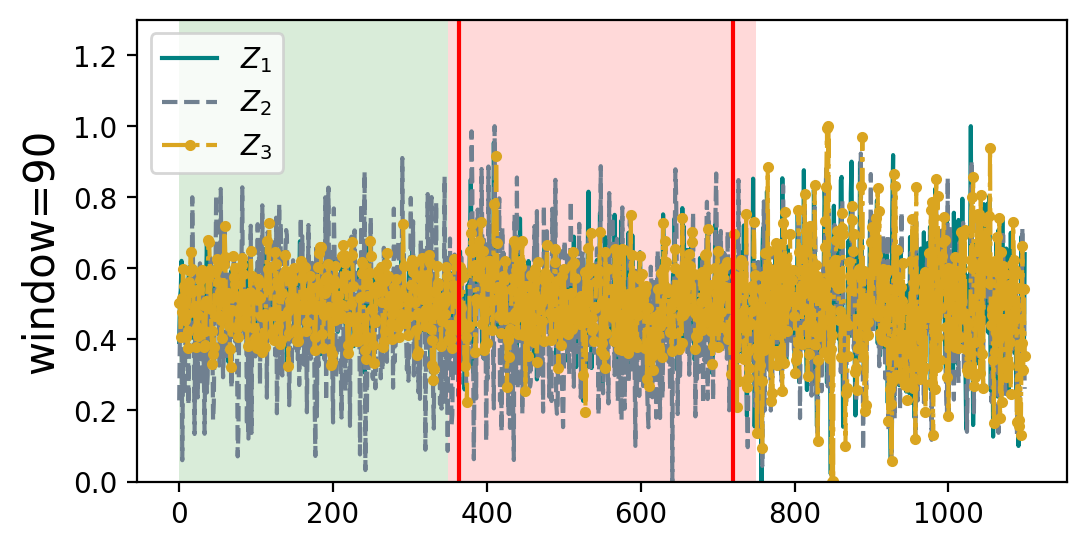

In [44]:
regimes.plot_regimes(data, clusters, cluster_idx, winsize, dtype='synthetic')